In [1]:
%pip install pytorch_tabnet
%pip install optuna
%pip install optuna-integration[sklearn]

  Using cached pytorch_tabnet-4.1.0-py3-none-any.whl.metadata (15 kB)
  Using cached numpy-2.2.6-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached scikit_learn-1.6.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached scipy-1.15.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached torch-2.7.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (29 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached joblib-1.5.0-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached typing_extensions-4.13.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import f1_score, roc_auc_score, classification_report

import torch
from sklearn.model_selection import train_test_split
import torch.optim as optim
from optuna import create_study, samplers, pruners
import optuna

# TabNet

In [10]:
# Load preprocessed and SMOTENC-applied data
X_train = pd.read_pickle('X_train_preprocessed_binary.pkl')
y_train = pd.read_pickle('y_train_binary.pkl')
X_test = pd.read_pickle('X_test_preprocessed_binary.pkl')
y_test = pd.read_pickle('y_test_binary.pkl')

# Convert data to numpy arrays (float32)
X_train_np = X_train.values.astype(np.float32)
X_test_np = X_test.values.astype(np.float32)
y_train_np = y_train.values.astype(np.long)
y_test_np = y_test.values.astype(np.long)

# Split original X_train into train and validation sets (stratified)
X_train_new_np, X_val_new_np, y_train_new_np, y_val_new_np = train_test_split(
    X_train_np, y_train_np, test_size=0.2, stratify=y_train_np, random_state=42
)

In [11]:
def objective(trial):
    # Shared value for n_d and n_a
    n_da = trial.suggest_int("n_da", 8, 32)

    params = {
        "n_d": n_da,
        "n_a": n_da,
        "n_steps": trial.suggest_int("n_steps", 2, 5),
        "gamma": trial.suggest_float("gamma", 1.0, 1.5),
        "lambda_sparse": trial.suggest_float("lambda_sparse", 1e-5, 1e-2, log=True),
        "lr": trial.suggest_float("lr", 1e-4, 5e-2, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [64, 128]),
        "virtual_batch_size": trial.suggest_categorical("virtual_batch_size", [32, 64])
    }

    # Initialize TabNetClassifier
    model = TabNetClassifier(
        n_d=params["n_d"],
        n_a=params["n_a"],
        n_steps=params["n_steps"],
        gamma=params["gamma"],
        lambda_sparse=params["lambda_sparse"],
        optimizer_fn=optim.Adam,
        optimizer_params=dict(lr=params["lr"]),
        verbose=0,
        device_name="cuda" if torch.cuda.is_available() else "cpu"
    )

    # Train with early stopping
    model.fit(
        X_train=X_train_new_np,
        y_train=y_train_new_np,
        eval_set=[(X_val_new_np, y_val_new_np)],
        eval_metric=['logloss'],
        max_epochs=50,
        batch_size=params["batch_size"],
        virtual_batch_size=params["virtual_batch_size"],
        drop_last=False,
        patience=10
    )

    # Predict probabilities for ROC AUC
    y_proba = model.predict_proba(X_val_new_np)

    # Convert y_val to 1D and use class 1 probabilities
    roc_auc = roc_auc_score(y_val_new_np.ravel(), y_proba[:, 1])

    # Report metric for pruning
    trial.report(roc_auc, step=50)  # Simulate per-epoch reporting if needed

    if trial.should_prune():
        raise optuna.TrialPruned()

    return roc_auc

# Run optuna study with pruning & TPE
study = create_study(
    direction="maximize",
    sampler=samplers.TPESampler(),  # Faster convergence
    pruner=pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=5)
)
study.optimize(objective, n_trials=100)

# Print Best Hyperparameters
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value:.4f}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params

[I 2025-05-22 17:25:59,381] A new study created in memory with name: no-name-185d5743-3c20-4d2a-b193-bae88c4be1da



Early stopping occurred at epoch 33 with best_epoch = 23 and best_val_0_logloss = 0.40333


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 17:29:11,943] Trial 0 finished with value: 0.8679921521290556 and parameters: {'n_da': 29, 'n_steps': 5, 'gamma': 1.4488923914980236, 'lambda_sparse': 0.0010085722999723299, 'lr': 0.04023784742001718, 'batch_size': 64, 'virtual_batch_size': 64}. Best is trial 0 with value: 0.8679921521290556.


Stop training because you reached max_epochs = 50 with best_epoch = 47 and best_val_0_logloss = 0.48797


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 17:31:41,957] Trial 1 finished with value: 0.7903552016180002 and parameters: {'n_da': 20, 'n_steps': 4, 'gamma': 1.296739114141025, 'lambda_sparse': 1.6007887438907548e-05, 'lr': 0.0001955574747539243, 'batch_size': 128, 'virtual_batch_size': 64}. Best is trial 0 with value: 0.8679921521290556.



Early stopping occurred at epoch 45 with best_epoch = 35 and best_val_0_logloss = 0.44795


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 17:34:56,224] Trial 2 finished with value: 0.8313815137061785 and parameters: {'n_da': 28, 'n_steps': 5, 'gamma': 1.056714056485077, 'lambda_sparse': 0.0006990776028522564, 'lr': 0.0013449704691254453, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 0 with value: 0.8679921521290556.


Stop training because you reached max_epochs = 50 with best_epoch = 48 and best_val_0_logloss = 0.46599


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 17:39:35,609] Trial 3 finished with value: 0.8101044899150942 and parameters: {'n_da': 32, 'n_steps': 5, 'gamma': 1.4348136489275587, 'lambda_sparse': 0.0030755114934978957, 'lr': 0.0004006760757084667, 'batch_size': 64, 'virtual_batch_size': 32}. Best is trial 0 with value: 0.8679921521290556.


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_logloss = 0.47887


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 17:42:29,874] Trial 4 finished with value: 0.8068850468504365 and parameters: {'n_da': 14, 'n_steps': 5, 'gamma': 1.4675932352339005, 'lambda_sparse': 0.0008795994665532686, 'lr': 0.0010117251381262199, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 0 with value: 0.8679921521290556.


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_logloss = 0.42405


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 17:44:22,462] Trial 5 finished with value: 0.8543237175549823 and parameters: {'n_da': 25, 'n_steps': 3, 'gamma': 1.2711902797214745, 'lambda_sparse': 0.0006990279868561147, 'lr': 0.0006957731434291811, 'batch_size': 128, 'virtual_batch_size': 64}. Best is trial 0 with value: 0.8679921521290556.



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_logloss = 0.4311


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 17:45:24,437] Trial 6 finished with value: 0.8469177344435721 and parameters: {'n_da': 26, 'n_steps': 4, 'gamma': 1.3716762506556128, 'lambda_sparse': 0.00033703124589087207, 'lr': 0.019821933506006115, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 0 with value: 0.8679921521290556.



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_logloss = 0.39178


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 17:46:22,377] Trial 7 finished with value: 0.8762204881418457 and parameters: {'n_da': 11, 'n_steps': 3, 'gamma': 1.0973464197870746, 'lambda_sparse': 8.239533735344089e-05, 'lr': 0.023089778927531644, 'batch_size': 128, 'virtual_batch_size': 64}. Best is trial 7 with value: 0.8762204881418457.


Stop training because you reached max_epochs = 50 with best_epoch = 48 and best_val_0_logloss = 0.41315


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 17:48:46,816] Trial 8 finished with value: 0.8623820282331074 and parameters: {'n_da': 24, 'n_steps': 4, 'gamma': 1.4676604992154696, 'lambda_sparse': 1.586932414401013e-05, 'lr': 0.0038173019764035764, 'batch_size': 128, 'virtual_batch_size': 64}. Best is trial 7 with value: 0.8762204881418457.



Early stopping occurred at epoch 31 with best_epoch = 21 and best_val_0_logloss = 0.40088


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 17:49:43,680] Trial 9 finished with value: 0.8695483735429896 and parameters: {'n_da': 18, 'n_steps': 2, 'gamma': 1.0123785960108944, 'lambda_sparse': 0.0008592643394526734, 'lr': 0.005423054859880297, 'batch_size': 128, 'virtual_batch_size': 64}. Best is trial 7 with value: 0.8762204881418457.



Early stopping occurred at epoch 37 with best_epoch = 27 and best_val_0_logloss = 0.39445


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 17:51:21,609] Trial 10 finished with value: 0.8732387244717197 and parameters: {'n_da': 8, 'n_steps': 2, 'gamma': 1.1285269656894727, 'lambda_sparse': 8.232344565090338e-05, 'lr': 0.009163628516520226, 'batch_size': 64, 'virtual_batch_size': 64}. Best is trial 7 with value: 0.8762204881418457.



Early stopping occurred at epoch 33 with best_epoch = 23 and best_val_0_logloss = 0.3995


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 17:52:50,042] Trial 11 finished with value: 0.8735050678231951 and parameters: {'n_da': 8, 'n_steps': 2, 'gamma': 1.128928391452337, 'lambda_sparse': 7.388815269622689e-05, 'lr': 0.013464300707768904, 'batch_size': 64, 'virtual_batch_size': 64}. Best is trial 7 with value: 0.8762204881418457.



Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_0_logloss = 0.39455


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 17:54:37,096] Trial 12 finished with value: 0.8741467131699309 and parameters: {'n_da': 8, 'n_steps': 3, 'gamma': 1.1558030624304767, 'lambda_sparse': 7.534968492374894e-05, 'lr': 0.01562448686100859, 'batch_size': 64, 'virtual_batch_size': 64}. Best is trial 7 with value: 0.8762204881418457.



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_logloss = 0.39179


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 17:56:01,270] Trial 13 finished with value: 0.8733037079765917 and parameters: {'n_da': 12, 'n_steps': 3, 'gamma': 1.1738032458608976, 'lambda_sparse': 7.027763052586538e-05, 'lr': 0.04929617166751565, 'batch_size': 64, 'virtual_batch_size': 64}. Best is trial 7 with value: 0.8762204881418457.



Early stopping occurred at epoch 40 with best_epoch = 30 and best_val_0_logloss = 0.39314


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 17:58:24,177] Trial 14 finished with value: 0.8704287665062553 and parameters: {'n_da': 13, 'n_steps': 3, 'gamma': 1.208819447217574, 'lambda_sparse': 0.0001738037206065158, 'lr': 0.021162152099006046, 'batch_size': 64, 'virtual_batch_size': 64}. Best is trial 7 with value: 0.8762204881418457.



Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_0_logloss = 0.41039


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 17:59:59,087] Trial 15 pruned. 



Early stopping occurred at epoch 31 with best_epoch = 21 and best_val_0_logloss = 0.39153


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:01:41,853] Trial 16 finished with value: 0.8756067946040547 and parameters: {'n_da': 17, 'n_steps': 3, 'gamma': 1.1965069892134053, 'lambda_sparse': 0.00019235047172349969, 'lr': 0.009860967308318118, 'batch_size': 64, 'virtual_batch_size': 64}. Best is trial 7 with value: 0.8762204881418457.



Early stopping occurred at epoch 49 with best_epoch = 39 and best_val_0_logloss = 0.40094


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:03:49,759] Trial 17 finished with value: 0.8705047883051057 and parameters: {'n_da': 16, 'n_steps': 4, 'gamma': 1.3124466083508242, 'lambda_sparse': 0.006631419471548558, 'lr': 0.0056850188166267974, 'batch_size': 128, 'virtual_batch_size': 64}. Best is trial 7 with value: 0.8762204881418457.



Early stopping occurred at epoch 37 with best_epoch = 27 and best_val_0_logloss = 0.39514


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:05:34,770] Trial 18 finished with value: 0.8730254361461398 and parameters: {'n_da': 21, 'n_steps': 2, 'gamma': 1.22350414350957, 'lambda_sparse': 0.00020520247871320653, 'lr': 0.0022414037542365824, 'batch_size': 64, 'virtual_batch_size': 32}. Best is trial 7 with value: 0.8762204881418457.



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_logloss = 0.3896


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:06:30,616] Trial 19 finished with value: 0.8788607768466442 and parameters: {'n_da': 16, 'n_steps': 3, 'gamma': 1.0740647203524574, 'lambda_sparse': 3.589061838642555e-05, 'lr': 0.030670564545334882, 'batch_size': 128, 'virtual_batch_size': 64}. Best is trial 19 with value: 0.8788607768466442.



Early stopping occurred at epoch 39 with best_epoch = 29 and best_val_0_logloss = 0.39429


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:08:16,454] Trial 20 finished with value: 0.8761873732599109 and parameters: {'n_da': 15, 'n_steps': 4, 'gamma': 1.0009882476496454, 'lambda_sparse': 3.157133922159911e-05, 'lr': 0.030485451663916096, 'batch_size': 128, 'virtual_batch_size': 64}. Best is trial 19 with value: 0.8788607768466442.


Stop training because you reached max_epochs = 50 with best_epoch = 40 and best_val_0_logloss = 0.39621


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:10:26,158] Trial 21 finished with value: 0.8719200044153175 and parameters: {'n_da': 15, 'n_steps': 4, 'gamma': 1.0157545692048624, 'lambda_sparse': 3.144170071016359e-05, 'lr': 0.030326562345826476, 'batch_size': 128, 'virtual_batch_size': 64}. Best is trial 19 with value: 0.8788607768466442.



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_logloss = 0.39436


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:11:23,725] Trial 22 finished with value: 0.8730683430630555 and parameters: {'n_da': 11, 'n_steps': 3, 'gamma': 1.0786852540188767, 'lambda_sparse': 3.683913147415236e-05, 'lr': 0.02876802302562464, 'batch_size': 128, 'virtual_batch_size': 64}. Best is trial 19 with value: 0.8788607768466442.



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_logloss = 0.3991


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:12:40,502] Trial 23 pruned. 



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_logloss = 0.39124


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:13:49,644] Trial 24 finished with value: 0.8767718687297593 and parameters: {'n_da': 20, 'n_steps': 3, 'gamma': 1.1092403828386923, 'lambda_sparse': 4.3299230408260905e-05, 'lr': 0.0254408666638804, 'batch_size': 128, 'virtual_batch_size': 64}. Best is trial 19 with value: 0.8788607768466442.



Early stopping occurred at epoch 31 with best_epoch = 21 and best_val_0_logloss = 0.39489


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:15:14,894] Trial 25 finished with value: 0.8746361368819667 and parameters: {'n_da': 22, 'n_steps': 3, 'gamma': 1.1043347854752141, 'lambda_sparse': 0.00011157329414158793, 'lr': 0.014718030869493828, 'batch_size': 128, 'virtual_batch_size': 64}. Best is trial 19 with value: 0.8788607768466442.



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_logloss = 0.38843


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:16:08,363] Trial 26 finished with value: 0.8779209195254958 and parameters: {'n_da': 23, 'n_steps': 2, 'gamma': 1.1492806409784664, 'lambda_sparse': 4.9841417394561676e-05, 'lr': 0.024529521127514862, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 19 with value: 0.8788607768466442.



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_logloss = 0.39579


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:17:00,707] Trial 27 pruned. 


Stop training because you reached max_epochs = 50 with best_epoch = 47 and best_val_0_logloss = 0.47472


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:18:59,774] Trial 28 pruned. 



Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_0_logloss = 0.393


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:20:19,359] Trial 29 finished with value: 0.8748805816824853 and parameters: {'n_da': 19, 'n_steps': 2, 'gamma': 1.046914091451976, 'lambda_sparse': 0.00033102912121993523, 'lr': 0.03511538613937312, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 19 with value: 0.8788607768466442.



Early stopping occurred at epoch 38 with best_epoch = 28 and best_val_0_logloss = 0.38861


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:21:59,705] Trial 30 finished with value: 0.8776244879210797 and parameters: {'n_da': 27, 'n_steps': 2, 'gamma': 1.11944159430174, 'lambda_sparse': 5.268998595671157e-05, 'lr': 0.007508822528272095, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 19 with value: 0.8788607768466442.



Early stopping occurred at epoch 33 with best_epoch = 23 and best_val_0_logloss = 0.38724


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:23:23,344] Trial 31 finished with value: 0.8782034642439392 and parameters: {'n_da': 27, 'n_steps': 2, 'gamma': 1.133247625789321, 'lambda_sparse': 4.818938607971681e-05, 'lr': 0.006739823865548595, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 19 with value: 0.8788607768466442.



Early stopping occurred at epoch 38 with best_epoch = 28 and best_val_0_logloss = 0.39755


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:24:51,223] Trial 32 pruned. 



Early stopping occurred at epoch 39 with best_epoch = 29 and best_val_0_logloss = 0.40006


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:26:24,875] Trial 33 pruned. 


Stop training because you reached max_epochs = 50 with best_epoch = 43 and best_val_0_logloss = 0.39357


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:28:18,791] Trial 34 finished with value: 0.8734484520573065 and parameters: {'n_da': 27, 'n_steps': 2, 'gamma': 1.1269116506676928, 'lambda_sparse': 4.5065538286593647e-05, 'lr': 0.0015274331067290814, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 19 with value: 0.8788607768466442.



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_logloss = 0.39661


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:29:26,111] Trial 35 finished with value: 0.8737701649156727 and parameters: {'n_da': 30, 'n_steps': 2, 'gamma': 1.1949296862566996, 'lambda_sparse': 2.118743572789168e-05, 'lr': 0.010308452469111797, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 19 with value: 0.8788607768466442.



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_logloss = 0.40019


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:30:33,271] Trial 36 pruned. 



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_logloss = 0.39625


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:31:28,243] Trial 37 finished with value: 0.8742207765617852 and parameters: {'n_da': 26, 'n_steps': 2, 'gamma': 1.0681003931775908, 'lambda_sparse': 0.0004768888401009075, 'lr': 0.012618736317691425, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 19 with value: 0.8788607768466442.


Stop training because you reached max_epochs = 50 with best_epoch = 43 and best_val_0_logloss = 0.41231


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:35:05,198] Trial 38 pruned. 



Early stopping occurred at epoch 33 with best_epoch = 23 and best_val_0_logloss = 0.39913


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:36:19,746] Trial 39 pruned. 


Stop training because you reached max_epochs = 50 with best_epoch = 48 and best_val_0_logloss = 0.41877


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:38:11,190] Trial 40 pruned. 



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_logloss = 0.39368


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:39:18,797] Trial 41 finished with value: 0.8742768582166746 and parameters: {'n_da': 21, 'n_steps': 3, 'gamma': 1.1055255291541461, 'lambda_sparse': 5.712519250900497e-05, 'lr': 0.026369082010625253, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 19 with value: 0.8788607768466442.



Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_logloss = 0.39772


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:40:14,182] Trial 42 pruned. 



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_logloss = 0.4023


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:41:26,066] Trial 43 pruned. 



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_logloss = 0.38992


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:42:22,572] Trial 44 finished with value: 0.8767403561808216 and parameters: {'n_da': 25, 'n_steps': 2, 'gamma': 1.4247665325253143, 'lambda_sparse': 6.031976102888637e-05, 'lr': 0.01267948829012207, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 19 with value: 0.8788607768466442.



Early stopping occurred at epoch 43 with best_epoch = 33 and best_val_0_logloss = 0.39161


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:44:08,926] Trial 45 finished with value: 0.87584767866458 and parameters: {'n_da': 19, 'n_steps': 3, 'gamma': 1.0849561298930759, 'lambda_sparse': 9.054686502318731e-05, 'lr': 0.02229072344732432, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 19 with value: 0.8788607768466442.



Early stopping occurred at epoch 36 with best_epoch = 26 and best_val_0_logloss = 0.40829


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:45:34,076] Trial 46 pruned. 


Stop training because you reached max_epochs = 50 with best_epoch = 46 and best_val_0_logloss = 0.4468


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:47:04,548] Trial 47 pruned. 



Early stopping occurred at epoch 32 with best_epoch = 22 and best_val_0_logloss = 0.40432


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:48:19,684] Trial 48 pruned. 



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_logloss = 0.39459


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:49:08,767] Trial 49 finished with value: 0.8757486900927751 and parameters: {'n_da': 23, 'n_steps': 2, 'gamma': 1.1903416171277987, 'lambda_sparse': 9.319681983989883e-05, 'lr': 0.017574699827608467, 'batch_size': 128, 'virtual_batch_size': 64}. Best is trial 19 with value: 0.8788607768466442.



Early stopping occurred at epoch 44 with best_epoch = 34 and best_val_0_logloss = 0.3926


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:51:19,906] Trial 50 finished with value: 0.8750294206141921 and parameters: {'n_da': 17, 'n_steps': 4, 'gamma': 1.0910845810162202, 'lambda_sparse': 0.00026241908277544455, 'lr': 0.038385832081193144, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 19 with value: 0.8788607768466442.



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_logloss = 0.39424


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:52:12,308] Trial 51 finished with value: 0.8744130565214063 and parameters: {'n_da': 25, 'n_steps': 2, 'gamma': 1.421735136098819, 'lambda_sparse': 6.159918050004348e-05, 'lr': 0.011917232626710496, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 19 with value: 0.8788607768466442.



Early stopping occurred at epoch 34 with best_epoch = 24 and best_val_0_logloss = 0.39063


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:53:16,848] Trial 52 finished with value: 0.8747945898116547 and parameters: {'n_da': 26, 'n_steps': 2, 'gamma': 1.3933239204009644, 'lambda_sparse': 5.808676580179837e-05, 'lr': 0.013986988431572752, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 19 with value: 0.8788607768466442.



Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_logloss = 0.39052


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:53:57,031] Trial 53 finished with value: 0.8778521972436312 and parameters: {'n_da': 24, 'n_steps': 2, 'gamma': 1.3400870293510372, 'lambda_sparse': 3.4564047775562033e-05, 'lr': 0.02320812667121171, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 19 with value: 0.8788607768466442.



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_logloss = 0.39341


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:54:53,104] Trial 54 pruned. 



Early stopping occurred at epoch 32 with best_epoch = 22 and best_val_0_logloss = 0.39431


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:56:02,316] Trial 55 pruned. 



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_logloss = 0.39452


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:56:45,010] Trial 56 pruned. 



Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_0_logloss = 0.38893


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:58:06,604] Trial 57 finished with value: 0.8769527543214031 and parameters: {'n_da': 14, 'n_steps': 3, 'gamma': 1.4869902977623275, 'lambda_sparse': 4.087974227211583e-05, 'lr': 0.033327476097151004, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 19 with value: 0.8788607768466442.



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_logloss = 0.39691


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 18:59:17,955] Trial 58 pruned. 


Stop training because you reached max_epochs = 50 with best_epoch = 44 and best_val_0_logloss = 0.40548


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:01:14,625] Trial 59 pruned. 



Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_0_logloss = 0.39277


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:02:25,732] Trial 60 finished with value: 0.8754369473063892 and parameters: {'n_da': 10, 'n_steps': 2, 'gamma': 1.488809448886558, 'lambda_sparse': 8.608133061682234e-05, 'lr': 0.008300928898541457, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 19 with value: 0.8788607768466442.



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_logloss = 0.39484


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:03:45,420] Trial 61 pruned. 



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_logloss = 0.41216


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:05:14,592] Trial 62 pruned. 



Early stopping occurred at epoch 32 with best_epoch = 22 and best_val_0_logloss = 0.38735


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:06:38,646] Trial 63 finished with value: 0.8799437759155108 and parameters: {'n_da': 20, 'n_steps': 3, 'gamma': 1.0325955847828647, 'lambda_sparse': 2.1351055688317123e-05, 'lr': 0.023858827454399014, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 63 with value: 0.8799437759155108.



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_logloss = 0.39809


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:07:49,204] Trial 64 pruned. 



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_logloss = 0.39463


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:08:54,129] Trial 65 pruned. 



Early stopping occurred at epoch 32 with best_epoch = 22 and best_val_0_logloss = 0.39132


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:09:59,301] Trial 66 finished with value: 0.8750415271301683 and parameters: {'n_da': 22, 'n_steps': 2, 'gamma': 1.2768278051927056, 'lambda_sparse': 7.652713307060714e-05, 'lr': 0.010401922127961993, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 63 with value: 0.8799437759155108.



Early stopping occurred at epoch 38 with best_epoch = 28 and best_val_0_logloss = 0.40124


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:12:29,717] Trial 67 pruned. 



Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_0_logloss = 0.39208


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:14:55,572] Trial 68 finished with value: 0.8744969119482411 and parameters: {'n_da': 26, 'n_steps': 4, 'gamma': 1.058529698290096, 'lambda_sparse': 1.6043149352752007e-05, 'lr': 0.024149529661534212, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 63 with value: 0.8799437759155108.



Early stopping occurred at epoch 39 with best_epoch = 29 and best_val_0_logloss = 0.39525


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:16:14,757] Trial 69 finished with value: 0.8749174353414128 and parameters: {'n_da': 19, 'n_steps': 2, 'gamma': 1.0226667177964601, 'lambda_sparse': 0.008778349771702849, 'lr': 0.004725544410009495, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 63 with value: 0.8799437759155108.



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_logloss = 0.39186


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:17:17,278] Trial 70 finished with value: 0.8769009455545053 and parameters: {'n_da': 28, 'n_steps': 2, 'gamma': 1.4005655345514842, 'lambda_sparse': 4.7514402253949774e-05, 'lr': 0.015347725819689548, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 63 with value: 0.8799437759155108.



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_logloss = 0.40043


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:18:17,882] Trial 71 pruned. 



Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_logloss = 0.39315


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:19:05,848] Trial 72 finished with value: 0.876033015181215 and parameters: {'n_da': 30, 'n_steps': 2, 'gamma': 1.4014632439133643, 'lambda_sparse': 3.750025919014925e-05, 'lr': 0.01855695678647789, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 63 with value: 0.8799437759155108.



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_logloss = 0.39092


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:19:47,233] Trial 73 finished with value: 0.8764172190264581 and parameters: {'n_da': 24, 'n_steps': 2, 'gamma': 1.4637929821842028, 'lambda_sparse': 6.921540809254471e-05, 'lr': 0.03451647787115135, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 63 with value: 0.8799437759155108.


Stop training because you reached max_epochs = 50 with best_epoch = 41 and best_val_0_logloss = 0.39651


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:23:03,721] Trial 74 pruned. 



Early stopping occurred at epoch 31 with best_epoch = 21 and best_val_0_logloss = 0.39595


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:24:07,395] Trial 75 pruned. 



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_logloss = 0.39367


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:25:02,555] Trial 76 finished with value: 0.875518844326228 and parameters: {'n_da': 28, 'n_steps': 2, 'gamma': 1.3447495315187168, 'lambda_sparse': 4.945352896337358e-05, 'lr': 0.027200741175484117, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 63 with value: 0.8799437759155108.



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_logloss = 0.39339


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:25:46,860] Trial 77 finished with value: 0.8750860363800806 and parameters: {'n_da': 27, 'n_steps': 2, 'gamma': 1.0945406910192754, 'lambda_sparse': 3.456044546453727e-05, 'lr': 0.015666349655612442, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 63 with value: 0.8799437759155108.



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_logloss = 0.39014


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:27:28,907] Trial 78 finished with value: 0.8763508112255889 and parameters: {'n_da': 14, 'n_steps': 3, 'gamma': 1.215717505235619, 'lambda_sparse': 2.244590796598154e-05, 'lr': 0.021746400952767753, 'batch_size': 64, 'virtual_batch_size': 32}. Best is trial 63 with value: 0.8799437759155108.



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_logloss = 0.39233


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:28:10,727] Trial 79 finished with value: 0.8751590315499367 and parameters: {'n_da': 29, 'n_steps': 2, 'gamma': 1.4547229862221398, 'lambda_sparse': 6.811204361665223e-05, 'lr': 0.04021706179714751, 'batch_size': 128, 'virtual_batch_size': 32}. Best is trial 63 with value: 0.8799437759155108.



Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_0_logloss = 0.39789


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:30:12,843] Trial 80 pruned. 



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_logloss = 0.39824


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:31:20,549] Trial 81 pruned. 



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_logloss = 0.39225


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:32:20,674] Trial 82 finished with value: 0.875043663574164 and parameters: {'n_da': 18, 'n_steps': 3, 'gamma': 1.1330373427909923, 'lambda_sparse': 4.5480726448649816e-05, 'lr': 0.024812213383747214, 'batch_size': 128, 'virtual_batch_size': 64}. Best is trial 63 with value: 0.8799437759155108.



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_logloss = 0.39073


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:33:28,985] Trial 83 finished with value: 0.8772961876937264 and parameters: {'n_da': 20, 'n_steps': 3, 'gamma': 1.0745822660399023, 'lambda_sparse': 2.9612369308517033e-05, 'lr': 0.027370229129354686, 'batch_size': 128, 'virtual_batch_size': 64}. Best is trial 63 with value: 0.8799437759155108.



Early stopping occurred at epoch 31 with best_epoch = 21 and best_val_0_logloss = 0.39485


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:34:42,272] Trial 84 pruned. 



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_logloss = 0.3939


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:35:28,990] Trial 85 pruned. 



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_logloss = 0.39731


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:36:44,047] Trial 86 pruned. 



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_logloss = 0.39617


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:37:33,485] Trial 87 pruned. 



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_logloss = 0.39098


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:38:14,369] Trial 88 finished with value: 0.8762019722938822 and parameters: {'n_da': 20, 'n_steps': 3, 'gamma': 1.185195157156052, 'lambda_sparse': 2.466236416671219e-05, 'lr': 0.023661902772120873, 'batch_size': 128, 'virtual_batch_size': 64}. Best is trial 63 with value: 0.8799437759155108.



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_logloss = 0.39243


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:39:31,980] Trial 89 pruned. 



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_logloss = 0.39688


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:40:20,504] Trial 90 pruned. 



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_logloss = 0.39642


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:41:23,793] Trial 91 pruned. 



Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_logloss = 0.38735


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:42:12,211] Trial 92 finished with value: 0.8767521066227983 and parameters: {'n_da': 17, 'n_steps': 3, 'gamma': 1.0606522272018881, 'lambda_sparse': 2.9236294498952303e-05, 'lr': 0.02723896006146712, 'batch_size': 128, 'virtual_batch_size': 64}. Best is trial 63 with value: 0.8799437759155108.



Early stopping occurred at epoch 33 with best_epoch = 23 and best_val_0_logloss = 0.40276


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:43:24,733] Trial 93 pruned. 



Early stopping occurred at epoch 37 with best_epoch = 27 and best_val_0_logloss = 0.39255


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:44:45,004] Trial 94 finished with value: 0.8784358025284814 and parameters: {'n_da': 18, 'n_steps': 3, 'gamma': 1.251315735105469, 'lambda_sparse': 4.828463686900262e-05, 'lr': 0.020898828537235948, 'batch_size': 128, 'virtual_batch_size': 64}. Best is trial 63 with value: 0.8799437759155108.



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_logloss = 0.39315


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:45:48,748] Trial 95 pruned. 


Stop training because you reached max_epochs = 50 with best_epoch = 47 and best_val_0_logloss = 0.41672


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:47:09,822] Trial 96 pruned. 



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_logloss = 0.38772


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:48:28,398] Trial 97 finished with value: 0.8795866336942143 and parameters: {'n_da': 15, 'n_steps': 3, 'gamma': 1.2360371461857191, 'lambda_sparse': 0.00010781803759364498, 'lr': 0.021623285268213468, 'batch_size': 64, 'virtual_batch_size': 32}. Best is trial 63 with value: 0.8799437759155108.



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_logloss = 0.3978


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:50:01,342] Trial 98 pruned. 


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_logloss = 0.40681


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-22 19:52:46,869] Trial 99 pruned. 


Best trial:
  Value: 0.8799
  Params:
    n_da: 20
    n_steps: 3
    gamma: 1.0325955847828647
    lambda_sparse: 2.1351055688317123e-05
    lr: 0.023858827454399014
    batch_size: 128
    virtual_batch_size: 32


Retraining best model for loss visualization...

Early stopping occurred at epoch 25 with best_epoch = 15 and best_valid_logloss = 0.39323


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


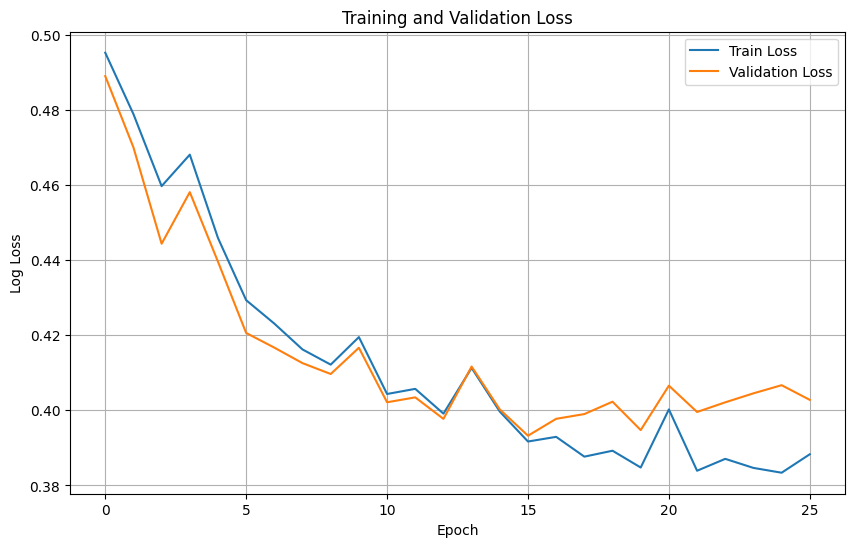

In [12]:
# After Optuna study completes
best_params = study.best_trial.params

# Retrain with best parameters
print("Retraining best model for loss visualization...")

# Initialize model using best params from study
plot_model = TabNetClassifier(
    n_d=best_params['n_da'],              # Shared embedding size
    n_a=best_params['n_da'],
    n_steps=best_params['n_steps'],
    gamma=best_params['gamma'],
    lambda_sparse=best_params['lambda_sparse'],
    optimizer_fn=torch.optim.Adam,        # Same optimizer
    optimizer_params={"lr": best_params['lr']},
    verbose=0,
    device_name="cuda" if torch.cuda.is_available() else "cpu"
)

# Retrain on full train/val set for loss tracking
plot_model.fit(
    X_train=X_train_new_np,
    y_train=y_train_new_np,
    eval_set=[(X_train_new_np, y_train_new_np), (X_val_new_np, y_val_new_np)],
    eval_name=["train", "valid"],
    eval_metric=["logloss"],
    max_epochs=50,
    batch_size=best_params["batch_size"],
    virtual_batch_size=best_params["virtual_batch_size"],
    drop_last=False,
    patience=10
)

# Extract loss history
train_losses = plot_model.history["train_logloss"]
valid_losses = plot_model.history["valid_logloss"]

# Plot training/validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# After Optuna study completes
best_params = study.best_trial.params

# Retrain final model on the full dataset
print("Retraining final model on full dataset...")

# Initialize model with best parameters from Optuna
best_model = TabNetClassifier(
    n_d=best_params['n_da'],
    n_a=best_params['n_da'],
    n_steps=best_params['n_steps'],
    gamma=best_params['gamma'],
    lambda_sparse=best_params['lambda_sparse'],
    optimizer_fn=torch.optim.Adam,
    optimizer_params={"lr": best_params['lr']},
    verbose=0,
    device_name="cuda" if torch.cuda.is_available() else "cpu"
)

# Train on full training dataset
best_model.fit(
    X_train=X_train_np,
    y_train=y_train_np,
    max_epochs=50,
    patience=10,
    batch_size=best_params["batch_size"],
    virtual_batch_size=best_params["virtual_batch_size"],
    drop_last=False
)

# Predict on test set
y_pred = best_model.predict(X_test_np)
y_proba = best_model.predict_proba(X_test_np)

# Evaluate metrics
roc_auc = roc_auc_score(y_test_np, y_proba[:, 1], multi_class="ovr", average="weighted")
f1 = f1_score(y_test_np, y_pred, average="weighted")

# Output results
print(f"Test ROC AUC (OvR weighted): {roc_auc:.4f}")
print(f"Test Weighted F1 Score: {f1:.4f}")

Retraining final model on full dataset...


/home/at/Downloads/001/.venv/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


Test ROC AUC (OvR weighted): 0.8425
Test Weighted F1 Score: 0.7980


In [ ]:
# Print classification report
print("\nClassification Report:\n")
print(classification_report(y_test_np, y_pred, digits=3))


Classification Report:

              precision    recall  f1-score   support

           0      0.858     0.859     0.858      3297
           1      0.650     0.647     0.648      1330

    accuracy                          0.798      4627
   macro avg      0.754     0.753     0.753      4627
weighted avg      0.798     0.798     0.798      4627

